# Inspección y preprocesado de datos

## Librerías

In [26]:
# Librerias necesarias
import os

# Matplotlib conf
import matplotlib.pyplot as plt
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':40,
         'ytick.labelsize': 40
}
plt.rcParams.update(params)
# Seaborn conf
import seaborn as sns
sns.set(style='darkgrid')
sns.set_palette(sns.color_palette("Blues"))

import sys

#Procesado de datos
import pandas as pd
import numpy as np

#Modelos
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer



import warnings
warnings.filterwarnings('ignore')


from wordcloud import WordCloud

from sklearn import preprocessing
from nltk import ngrams

## Inspección de datos

In [27]:
training_set = pd.read_json("./data/ds_training.json", lines=True)
print(training_set.shape)

(10000, 12)


Se observa que se tienen 10.000 ejemplos de entrenamiento y 12 características.

In [28]:
testing_set = pd.read_json("./data/ds_testing.json", lines=True)
print(testing_set.shape)

(2000, 12)


Se observa que hay disponibles 2.000 ejemplos de testing, para hacer una validación con holdout.

In [29]:
training_set[training_set["overall"]==1].shape

(5000, 12)

Se observa que:
* Por cada clase del conjunto de entrenamiento hay 5.000 ejemplos.
* Se sabe además de antemano que todas las clases están balanceadas. 
* Se sabe también que se han filtrado 2 clases de las 5 disponibles en la creación del dataset.

Se debe pasar a analizar las palabras considerando 2 sentimientos polarizados y extremos (rating=1 y rating=5):

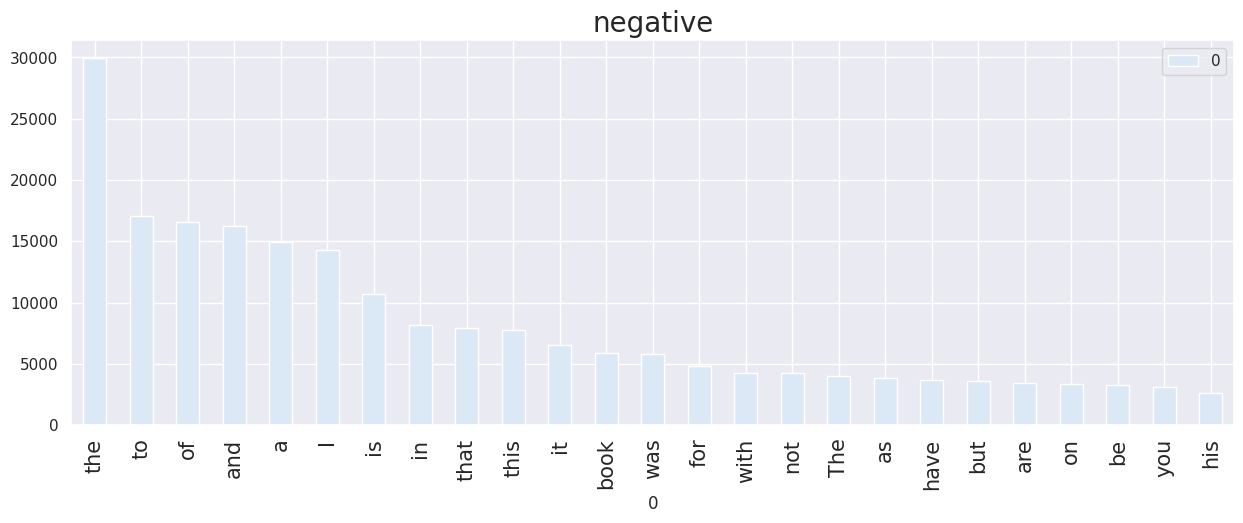

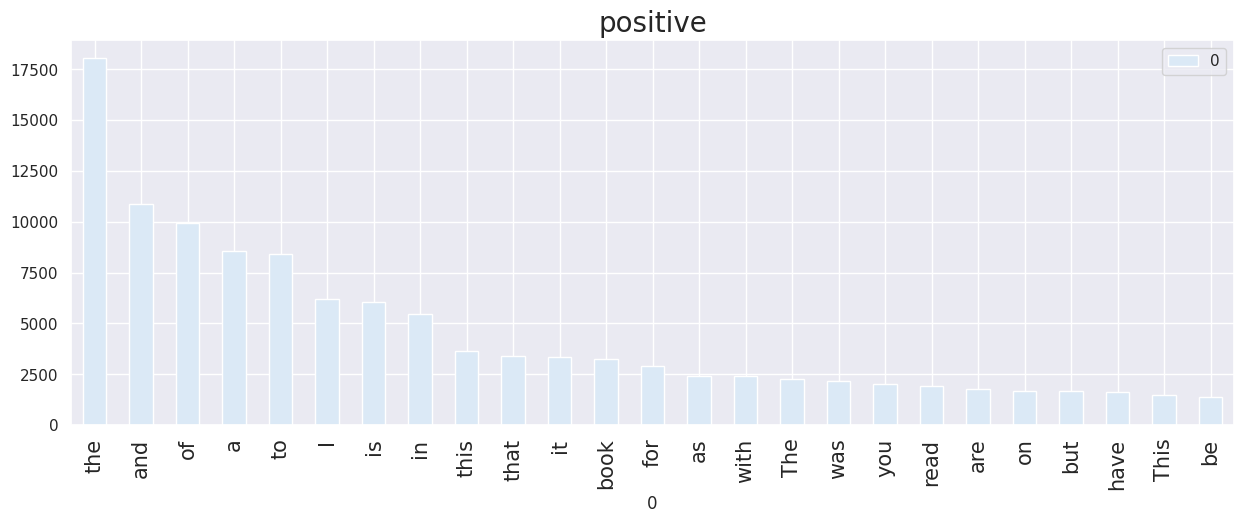

In [30]:
from nltk.tokenize import WhitespaceTokenizer

tokenizer = WhitespaceTokenizer()

def graph_tokens(target, label):
  text = target.str.cat(sep=" ")
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(25).plot(kind="bar")
  plt.title(label, fontsize=20)
  plt.xticks(fontsize=15)
  plt.show()

sentiment = ["negative","positive"]
for i, item in enumerate([1,5]):
    graph_tokens(training_set[training_set["overall"]==item]["reviewText"], sentiment[i])

Por otra parte, también sería necesario comprobar la presencia de emoticonos:

In [31]:
# Se prueba la presencia de emoticonos

display(
  training_set["reviewText"].str.contains(":\)").loc[lambda x: x==True].shape,
  training_set["reviewText"].str.contains(":-\)").loc[lambda x: x==True].shape,
  training_set["reviewText"].str.contains(";-\)").loc[lambda x: x==True].shape,
  training_set["reviewText"].str.contains(":\(").loc[lambda x: x==True].shape,
  training_set["reviewText"].str.contains(":S").loc[lambda x: x==True].shape
)

(27,)

(5,)

(2,)

(13,)

(1,)

Se observa que:
* Aparecen palabras que se deberían filtrar con stopwords. Por lo no se puede extraer algún valor a los listados.
* Se identifica como diferentes la misma palabra escrita en mayúscula o minúscula.
* Se identifican diferentes emoticonos en el texto. Aunque con codificación textual y no en UTF8. Con lo cual no se identifican todos los posibles emojis pero sí se observa que no son representativos en el dataset. Pero, al haber tan pocos en proporción al total de ejemplos, será mejor no considerarlos, eliminándolos en el preproceso.

## Preproceso

Se debe considerar que el pipeline de pre-proceso debe ser diferente en función del modelo de representación:
* Usando modelos de lenguaje (sin que apliquen representaciones distribuidas) puede considerarse el uso de Lemmatization y Stemming al mismo tiempo. Simplemente para reducir el número de palabras y considerar su stem.
* No sería correcto usar Lemmatization y Stemming al mismo tiempo cuando se trabaja con embeddings pre-entrenados, ya que, en la representación distribuida, el stemming hace irreconocible (out of the vocabulary: OOV) algunas palabras.

En consecuencia de lo expuesto en el punto anterior, se obtará por hacer un preproceso homogéneo para poder comparar mejor los distintos modelos de representación y sus resultados. Es por ello que se ha optado por solamente Lematizar.

Los ajustes que se aplicarán son los siguientes:
* Se utilizará exclusivamente la lematización, descartando así el uso del stemming. El motivo es el de disponer de unas representaciones más homogéneas y legibles en la sección de interpretabilidad de resultados. Usar ambas (lematización y stemming) busca reducir la dimensionalidad, pero en esta práctica se utilizará otra forma de conseguirlo, via Latent Semantic Indexing (LSI).
* Se modifica el orden de pasos: Se procesan los stopwords después de la lematización.
* Se incluyen los apóstrofes, para que el proceso de lematización identifique mejor las relaciones sintácticas.
* Se eliminan todos los emoticonos y contenido no alfanumérico.

In [32]:
from nltk.stem import *
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import re

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

def process_text(raw_text):
    #Consideramos únicamente letras utilizando una expresión regular
    raw_text = re.sub("<br\s?/>", "",raw_text)
    letters_only = re.sub("[^a-zA-Z']", " ",raw_text)
    #Convertimos todo a minúsculas
    words = letters_only.lower().split()

    #Lematización
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmatizer.lemmatize(word) for word in words]

    #Eliminamos las stopwords
    stops = set(stopwords.words("english"))
    not_stop_words = [w for w in lemmatized if not w in stops]

    return( " ".join( not_stop_words ))


[nltk_data] Downloading package stopwords to /home/david/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/david/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [33]:
training_set['processed'] = training_set['reviewText'].apply(lambda x: process_text(x))
testing_set['processed'] = testing_set['reviewText'].apply(lambda x: process_text(x))

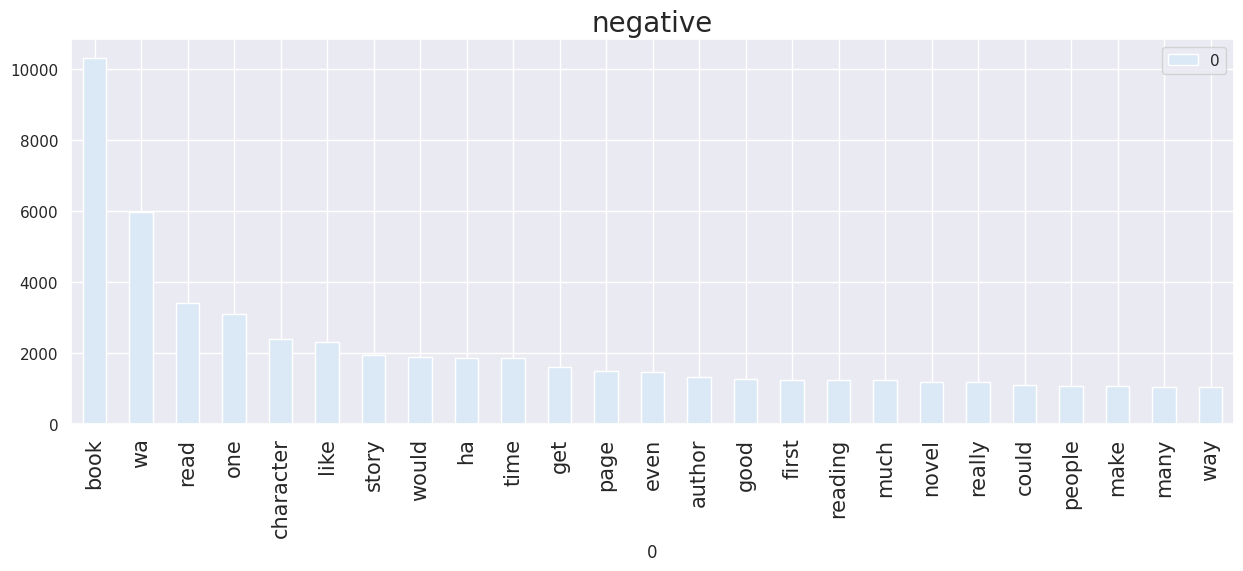

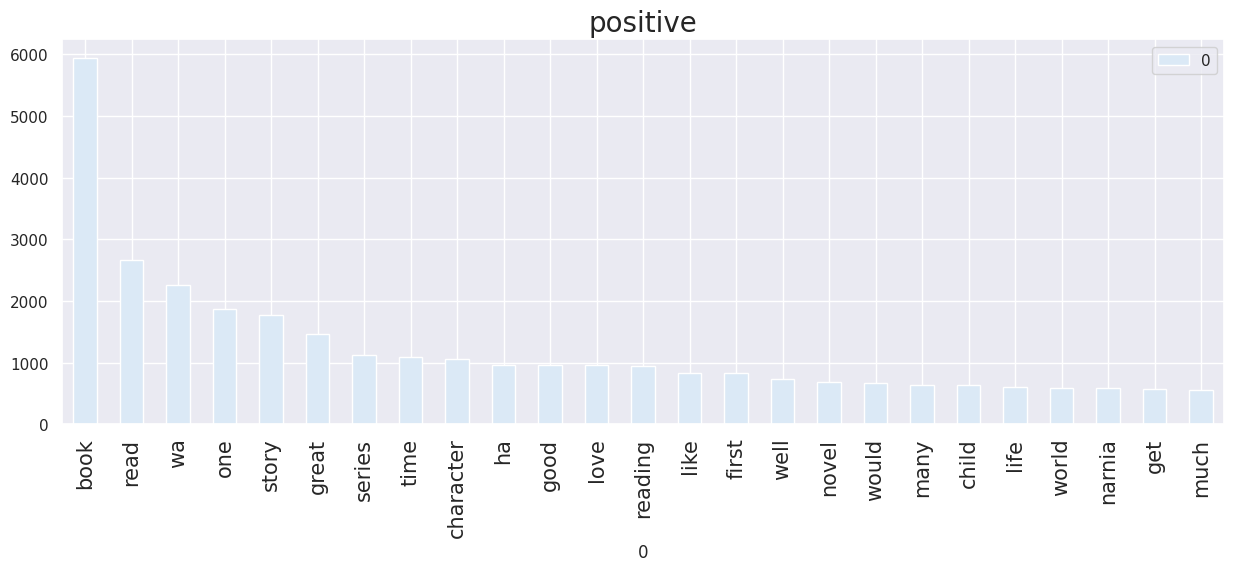

In [34]:
sentiment = ["negative","positive"]
for i, item in enumerate([1,5]):
    graph_tokens(training_set[training_set["overall"]==item]["processed"], sentiment[i])

Se puede observar que, a pesar de hacer el preproceso, no se observa una diferencia notable entre los listados de palabras ordenadas por frecuencia entre 2 sentimientos completamente opuestos. Hecho que demuestra la dificultad de esta tarea, cuando se lleva el mismo exclusivamente a los tokens y no al contexto semántico que expone el documento.

Como tarea final de preprocesado, se debería hacer la selección de características del dataset. Pero, también habría que persistir los datos preprocesados, por los siguientes motivos:
* Se utilizarán los datos preprocesados con múltiples modelos clasificadores.
* Todos estos modelos clasificadores se entrenarán con diferentes modelos de representación de textos.
* Los experimentos tomarán lugar en un largo periodo de tiempo. Además, puede haber fallos en el entrenamiento y que se deba reiniciar la sesión de Jupyter por algún motivo en particular.

In [35]:
df = training_set[['overall','processed']]
df.rename(columns={"overall": "sentiment", "processed":"text"}, inplace=True)
df.loc[df["sentiment"]==1, "sentiment"] = 0
df.loc[df["sentiment"]==5, "sentiment"] = 1
df.to_csv('./data/ds_training_processed.csv', index=False) 
df = pd.read_csv('./data/ds_training_processed.csv')
display(
    df["sentiment"].isna().sum(),
    df["text"].isna().sum()
)

0

7

Se puede observar que tras el preproceso quedaron textos vacíos (considerando que el preproceso ha eliminado palabras) y que por lo tanto, se ha producido valores nulos. Estos valores nulos es mejor eliminarlos, ya que no son significativos:

In [36]:
df.dropna(inplace=True)
df.to_csv('./data/ds_training_processed.csv', index=False) 

También se debe aplicar las mismas operaciones al conjunto de datos de testing:

In [37]:
df2 = testing_set[['overall','processed']]
df2.rename(columns={"overall": "sentiment", "processed":"text"}, inplace=True)
df2.loc[df2["sentiment"]==1, "sentiment"] = 0
df2.loc[df2["sentiment"]==5, "sentiment"] = 1
df2.dropna()
df2.to_csv('./data/ds_testing_processed.csv', index=False)
df2 = pd.read_csv('./data/ds_testing_processed.csv')
df2.dropna(inplace=True)
df2.to_csv('./data/ds_testing_processed.csv', index=False) 
df2.head()

,sentiment,text
0,1,king mouse cheese nancy gurney excellent child...
1,1,kid loved
2,1,student year old loved book definitely recomme...
3,1,love
4,1,great


## Inspección de los datos preprocesados

Con el propósito de conocer mejor el dataset y ya pensando en el siguiente paso (la creación de los modelos de representación), se reducirá la dimensionalidad del vocabulario a través de las siguientes técnicas:
* Se eliminarán todas las palabras que solo aparezcan en 5 documentos.
* Se eliminarán todas las palabras que aparezcan en el 90% de los documentos (las más repetidas).

El propósito es simplemente el de generar un mayor conocimiento sobre la efectividad de estas medidas:

In [38]:
negative = df[df["sentiment"]==0]["text"]
positive = df[df["sentiment"]==1]["text"]

negative_vsm_binary_cv = CountVectorizer(binary=True, max_df=0.9, min_df=5)
negative_vsm_binary_cv.fit(negative)
negative_vsm_tfidf_v = TfidfVectorizer(norm='l2', use_idf=True, max_df=0.9, min_df=5)
negative_vsm_tfidf_v.fit(negative)

positive_vsm_binary_cv = CountVectorizer(binary=True, max_df=0.9, min_df=5)
positive_vsm_binary_cv.fit(positive)
positive_vsm_tfidf_v = TfidfVectorizer(norm='l2', use_idf=True, max_df=0.9, min_df=5)
positive_vsm_tfidf_v.fit(positive)

def top_50_words_by_vectorizer(title, vectorizer, target_df):
    freqs = zip(vectorizer.get_feature_names_out(), vectorizer.transform(target_df).toarray().sum(axis=0))  
    freqs_ord = sorted(freqs, key=lambda x: -x[1])

    top = freqs_ord[:50]
    toplinspace = np.linspace(0, len(top)-1, num=len(top), dtype=int)

    fig = plt.figure(figsize=(12,2))
    plt.title(title)
    plt.bar(toplinspace, np.array([x[1] for x in top]))
    plt.ylabel("frequency")
    plt.xticks(toplinspace, [x[0] for x in top], rotation=90)
    cosa = np.array([x[1] for x in top])    

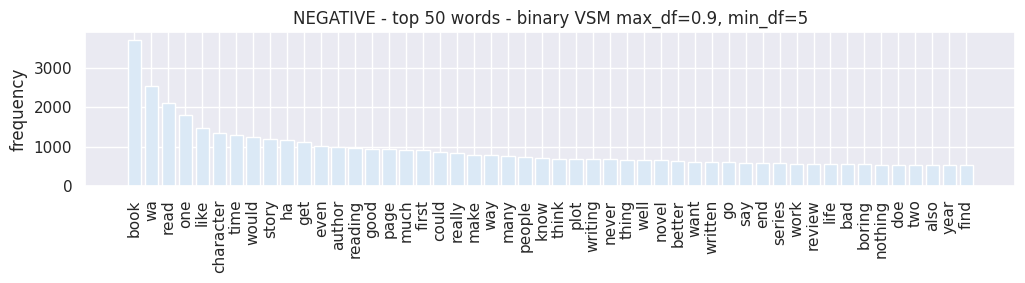

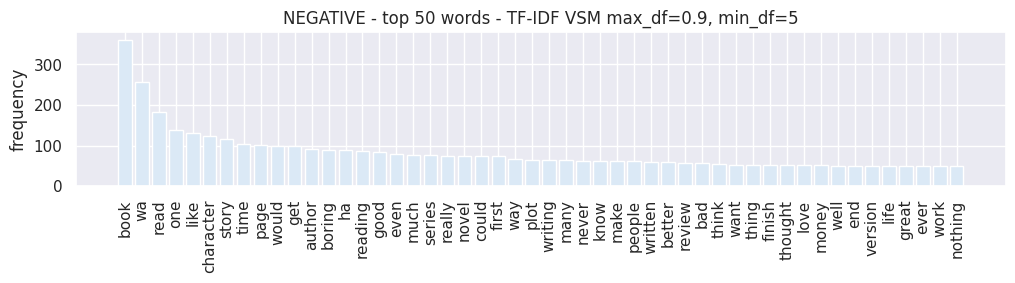

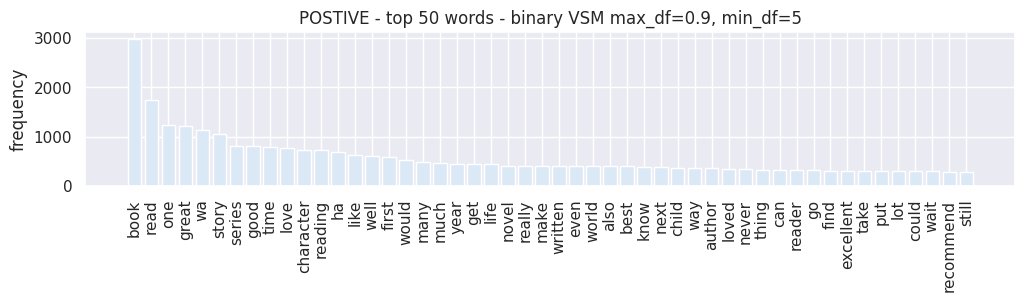

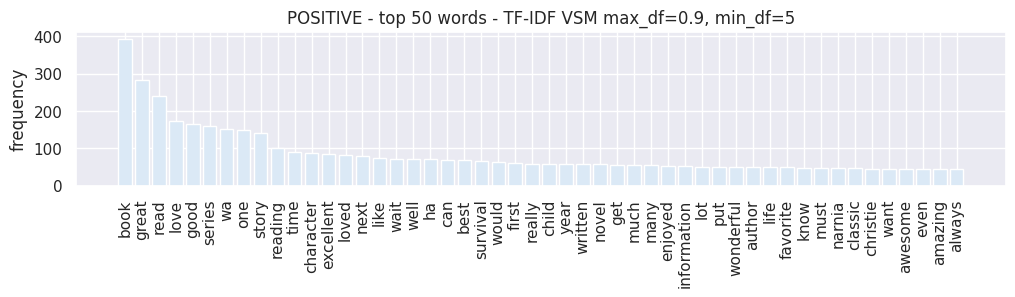

In [39]:
top_50_words_by_vectorizer("NEGATIVE - top 50 words - binary VSM max_df=0.9, min_df=5", 
                           negative_vsm_binary_cv, 
                           negative)
top_50_words_by_vectorizer("NEGATIVE - top 50 words - TF-IDF VSM max_df=0.9, min_df=5", 
                           negative_vsm_tfidf_v, 
                           negative)
top_50_words_by_vectorizer("POSTIVE - top 50 words - binary VSM max_df=0.9, min_df=5", 
                           positive_vsm_binary_cv, 
                           positive)
top_50_words_by_vectorizer("POSITIVE - top 50 words - TF-IDF VSM max_df=0.9, min_df=5", 
                           positive_vsm_tfidf_v, 
                           positive)

Se observa que:
* En cuanto a las palabras negativas, aproximadamente guardan un buen grado de coincidencia los listados con pesado binario y pesado TF-IDF.
* Sin embargo, no resulta ser el caso de los listados positivos. Ciertamente coinciden algunos aspectos de las primeras 10 palabras, pero varían considerablemente a partir de allí.
* En cuanto a la comparación entre los listados de sentimientos opuestos, se observa que hay un mayor nivel de similitud entre los listados de pesado binario.
* Aunque los listados de pesado TF-IDF se observan menos similares. Se muestran buenas palabras diferenciales en el top 10, como "excellent" y "boring" en ambos listados.

En definitva, parece que las palabras con mayor frecuencia observadas en los listados no parecen ser claros indicativos del sentimiento expresado en los documentos y que seguramente se deba analizar las influencias de los términos a larga distancia.